# 3.2 线性回归的从零开始实现
**小结**：本节将介绍如何只使用`Tensor`和`autograd`来实现一个线性回归的训练。  
**相关知识**：Python中的for

In [1]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

print(torch.__version__)

1.0.0


## 3.2.1 生成数据集
单样本参数的个数；
样本数量；
所有样本特征构成的集合；
标签。

In [2]:
num_inputs = 2        # 单样本参数的个数
num_examples = 200   # 样本数量
true_w = [-1, 2]
true_b = 0.2
features = torch.randn(num_examples, num_inputs,  # 所有样本特征构成的集合
                      dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),
                       dtype=torch.float32)       # 生成样本的标签

In [3]:
print(features[0], labels[0])
print(features[1], labels[1])

tensor([-0.7934, -1.5975]) tensor(-2.2050)
tensor([0.4071, 0.0554]) tensor(-0.1140)


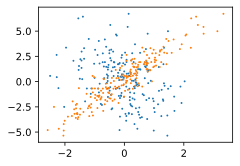

In [4]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

# # 在../d2lzh_pytorch里面添加上面两个函数后就可以这样导入
# import sys
# sys.path.append("..")
# from d2lzh_pytorch import * 

set_figsize()
# 注意这里是如何将`torch`转换为`numpy`的
plt.scatter(features[:, 0].numpy(), labels.numpy(), 1);
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);

## 3.2.2 读取数据
**说明**:`data_iter`函数每次返回`batch_size`（批量大小）个随机样本的特征和标签


In [5]:
# 本函数已保存在d2lzh包中方便以后使用
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield  features.index_select(0, j), labels.index_select(0, j)

In [6]:
batch_size = 5

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.3208, -1.7411],
        [ 0.2005,  0.4344],
        [-0.6093,  0.3375],
        [ 0.1434,  3.3328],
        [-2.4984, -1.0701]]) 
 tensor([-1.9572,  0.8572,  1.4629,  6.7162,  0.5662])


## 3.2.3 初始化模型参数

In [7]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

In [8]:
print(w)
print(b)

tensor([[0.0006],
        [0.0032]])
tensor([0.])


In [9]:
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

tensor([0.], requires_grad=True)

## 3.2.4 定义模型

In [10]:
# 使用`mm`函数做矩阵乘法
def linreg(X, w, b):  # 本函数已保存在d2lzh包中方便以后使用
    return torch.mm(X, w) + b

## 3.2.5 定义损失函数

In [11]:
def squared_loss(y_hat, y):  # 本函数已保存在pytorch_d2lzh包中方便以后使用
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

## 3.2.6 定义优化算法

In [12]:
def sgd(params, lr, batch_size):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data

## 3.2.7 训练模型

In [13]:
lr = 0.03                  # 学习率
num_epochs = 3             # 迭代次数
net = linreg               # 网络名
loss = squared_loss        # 损失函数

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数
        
        # 不要忘了梯度清零
        # 注意：并不是将参数清0
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.193412
epoch 2, loss 0.019274
epoch 3, loss 0.002571


In [14]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[-1, 2] 
 tensor([[-0.9247],
        [ 1.9724]], requires_grad=True)
0.2 
 tensor([0.2016], requires_grad=True)
